## Домашка

### Задание 1 (8 баллов)
Обучите модель с минимум 15 слоями, где у каждого слоя разные параметры (Dropout, Conv1d и Pooling, Dense считаются слоями, остальное нет, но их тоже можно использовать). Как минимум 4 слоя должны быть наложены друг на друга и как минимум 2 параллельных слоя (последовательности слоев). Должен быть хотя бы один слой каждого типа.

При обучении используйте колбек для отслеживания лучшей модели. Ориентируйтесь на Recall@Precision меру. Качество модели не должно быть околонулевым. Если метрики не растут, то попробуйте пообучать подольше или перестроить саму сеть.

Советы: Начните с небольших сетей и постепенно добавляйте, не пытайтесь сразу собрать все слои. Иногда кернел может крашиться просто так или из-за слишком больших матриц.


In [1]:
import os
os.environ["KERAS_BACKEND"] = "torch"

In [2]:
import keras
print(keras.__version__)

3.8.0


In [3]:
import pandas as pd
import numpy as np
from string import punctuation
from sklearn.model_selection import train_test_split
from collections import Counter
import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
data = pd.read_csv('lenta_40k.csv.zip')

In [5]:
def preprocess(text):
    tokens = text.lower().split()
    tokens = [token.strip(punctuation) for token in tokens]
    return tokens

In [6]:
vocab = Counter()

for text in data.text:
    vocab.update(preprocess(text))

filtered_vocab = set()

for word in vocab:
    if vocab[word] > 30:
        filtered_vocab.add(word)

word2id = {'PAD':0}

for word in filtered_vocab:
    word2id[word] = len(word2id)

id2word = {i:word for word, i in word2id.items()}

In [7]:
X = []

for text in data.text:
    tokens = preprocess(text)
    ids = [word2id.get(token, 1) for token in tokens]
    X.append(ids)


MAX_LEN = max(len(x) for x in X)
MEAN_LEN = np.median([len(x) for x in X])
MAX_LEN = int(MEAN_LEN + 30)
X = keras.preprocessing.sequence.pad_sequences(X, maxlen=MAX_LEN)

X.shape

id2label = {i:label for i, label in enumerate(set(data.topic.values))}
label2id = {l:i for i, l in id2label.items()}

In [8]:
y = keras.utils.to_categorical([label2id[label] for label in data.topic.values])

In [9]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.05)

In [ ]:
inputs = keras.layers.Input(shape=(MAX_LEN,))
embeddings = keras.layers.Embedding(input_dim=len(word2id), output_dim=100)(inputs, )
drop1 = keras.layers.Dropout(0.3)(embeddings)
convs = []
for ks in [3, 5, 10]:
    conv1 = keras.layers.Conv1D(kernel_size=ks, filters=32, padding='same',strides=1)(drop1)
    conv2 = keras.layers.Conv1D(kernel_size=ks, filters=24, padding='same',strides=1,
                                  kernel_regularizer='l2', activation='relu')(conv1)
    convs.append(conv2)
concat1 = keras.layers.concatenate(convs, axis=2)
conv3 = keras.layers.Conv1D(kernel_size=4, filters=32, strides=1)(concat1)
conv4 = keras.layers.Conv1D(kernel_size=6, filters=32, strides=1, activation='relu')(conv3)
drop2 = keras.layers.Dropout(0.5)(conv4)
conv_global = keras.layers.Conv1D(kernel_size=8, filters=32, strides=1)(drop2)
conv5 = keras.layers.Conv1D(kernel_size=4, filters=32, strides=1)(conv_global)
pool = keras.layers.AveragePooling1D(pool_size=5)(conv5)
concat2 = keras.layers.Flatten()(pool)
dense = keras.layers.Dense(64, activation='relu')(concat2)
outputs = keras.layers.Dense(len(label2id), activation='softmax')(dense)

model = keras.Model(inputs=inputs, outputs=outputs)
optimizer = keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=optimizer,
              loss='categorical_crossentropy',
              metrics=[keras.metrics.RecallAtPrecision(0.8, name='rec@prec')])

In [ ]:
model.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_4             │ (None, 200)            │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding_4 (Embedding)   │ (None, 200, 100)       │      2,409,200 │ input_layer_4[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_8 (Dropout)       │ (None, 200, 100)       │              0 │ embedding_4[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_36 (Conv1D)        │ (None, 200, 32)        │          9,632 │ dropout_8[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_38 (Conv1D)        │ (None, 200, 32)        │         16,032 │ dropout_8[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_40 (Conv1D)        │ (None, 200, 32)        │         32,032 │ dropout_8[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_37 (Conv1D)        │ (None, 200, 24)        │          2,328 │ conv1d_36[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_39 (Conv1D)        │ (None, 200, 24)        │          3,864 │ conv1d_38[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_41 (Conv1D)        │ (None, 200, 24)        │          7,704 │ conv1d_40[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate_4             │ (None, 200, 72)        │              0 │ conv1d_37[0][0],       │
│ (Concatenate)             │                        │                │ conv1d_39[0][0],       │
│                           │                        │                │ conv1d_41[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_42 (Conv1D)        │ (None, 197, 32)        │          9,248 │ concatenate_4[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_43 (Conv1D)        │ (None, 192, 32)        │          6,176 │ conv1d_42[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_9 (Dropout)       │ (None, 192, 32)        │              0 │ conv1d_43[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_44 (Conv1D)        │ (None, 185, 32)        │          8,224 │ dropout_9[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_45 (Conv1D)        │ (None, 182, 32)        │          4,128 │ conv1d_44[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ average_pooling1d_3       │ (None, 36, 32)         │              0 │ conv1d_45[0][0]        │
│ (AveragePooling1D)        │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ flatten_4 (Flatten)       │ (None, 1152)           │              0 │ average_pooling1d_3[0… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_6 (Dense)      

 Total params: 2,583,595 (9.86 MB)

 Trainable params: 2,583,595 (9.86 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
model.save('model.keras')

In [ ]:
model = keras.models.load_model('model.keras')

In [ ]:
model.save_weights('model.weights.h5')

In [33]:
# ModelCheckpoint сохраняет лучшие версии моделей
checkpoint = keras.callbacks.ModelCheckpoint('model.weights.h5', # названия файла
                                                monitor='val_rec@prec', # за какой метрикой следить
                                                verbose=1, # будет печатать что происходит
                                                save_weights_only=True, # если нужно только веса сохранить
                                                save_best_only=True, # сохранять только лучшие
                                                mode='max', # если метрика должна расти, то тут max и min если наоборот
                                                save_freq='epoch' # как часто вызывать
                                               )

# EarlyStopping позволяет автоматически остановить обучение, если качество не улучшается
early_stop = keras.callbacks.EarlyStopping(monitor='val_rec@prec',
                                              min_delta=0.01, # какая разница считается как улучшение
                                              patience=3, # сколько эпох терпеть отсутствие улучшений
                                              verbose=1,
                                              mode='max',
                                              )

In [ ]:
model.fit(X_train, y_train,
          validation_data=(X_valid, y_valid),
          batch_size=2500,
         epochs=100,
         callbacks=[checkpoint, early_stop])

/usr/local/lib/python3.11/dist-packages/keras/src/backend/torch/nn.py:466: UserWarning: Using padding='same' with even kernel lengths and odd dilation may require a zero-padded copy of the input be created (Triggered internally at ../aten/src/ATen/native/Convolution.cpp:1036.)
  outputs = tnn.conv1d(


Epoch 1/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 217ms/step - loss: 3.4551 - rec@prec: 6.3846e-05
Epoch 1: val_rec@prec improved from -inf to 0.00000, saving model to model.weights.h5
17/17 ━━━━━━━━━━━━━━━━━━━━ 6s 230ms/step - loss: 3.4431 - rec@prec: 6.2936e-05 - val_loss: 2.9485 - val_rec@prec: 0.0000e+00
Epoch 2/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step - loss: 2.8260 - rec@prec: 3.0346e-05
Epoch 2: val_rec@prec did not improve from 0.00000
17/17 ━━━━━━━━━━━━━━━━━━━━ 4s 221ms/step - loss: 2.8205 - rec@prec: 3.3934e-05 - val_loss: 2.5428 - val_rec@prec: 0.0000e+00
Epoch 3/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step - loss: 2.3718 - rec@prec: 0.0175
Epoch 3: val_rec@prec improved from 0.00000 to 0.18305, saving model to model.weights.h5
17/17 ━━━━━━━━━━━━━━━━━━━━ 4s 228ms/step - loss: 2.3653 - rec@prec: 0.0203 - val_loss: 2.0563 - val_rec@prec: 0.1830
Epoch 4/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 229ms/step - loss: 1.8515 - rec@prec: 0.2632
Epoch 4: val_rec@prec improved from 0.18305 to 0.28

dict_keys(['loss', 'rec@prec', 'val_loss', 'val_rec@prec'])


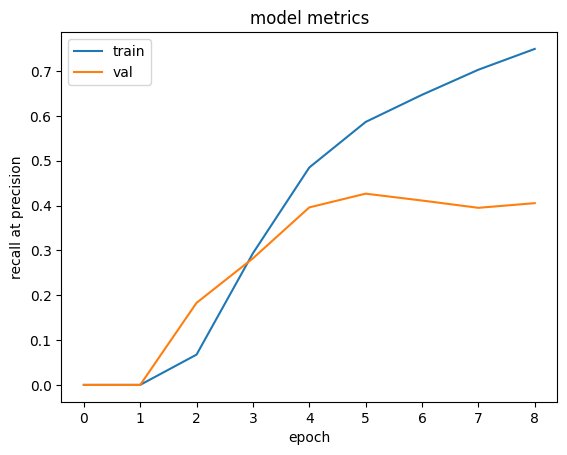

In [ ]:
print(model.history.history.keys())
plt.plot(model.history.history['rec@prec'])
plt.plot(model.history.history['val_rec@prec'])
plt.title('model metrics')
plt.ylabel('recall at precision')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
inputs = keras.layers.Input(shape=(MAX_LEN,))
embeddings = keras.layers.Embedding(input_dim=len(word2id), output_dim=100)(inputs, )
drop1 = keras.layers.Dropout(0.3)(embeddings)
convs = []
for ks in [3, 5, 10]:
    conv1 = keras.layers.Conv1D(kernel_size=ks, filters=32, padding='same',strides=1)(drop1)
    conv2 = keras.layers.Conv1D(kernel_size=ks, filters=24, padding='same',strides=1,
                                  kernel_regularizer='l2', activation='relu')(conv1)
    convs.append(conv2)
concat1 = keras.layers.concatenate(convs, axis=2)
conv3 = keras.layers.Conv1D(kernel_size=4, filters=128, strides=1)(concat1)
conv4 = keras.layers.Conv1D(kernel_size=6, filters=32, strides=2, activation='relu')(conv3)
drop2 = keras.layers.Dropout(0.5)(conv4)
conv_global = keras.layers.Conv1D(kernel_size=8, filters=64, strides=1)(drop2)
conv5 = keras.layers.Conv1D(kernel_size=4, filters=32, strides=1)(conv_global)
pool = keras.layers.AveragePooling1D(pool_size=5)(conv5)
concat2 = keras.layers.Flatten()(pool)
dense = keras.layers.Dense(64, activation='relu')(concat2)
outputs = keras.layers.Dense(len(label2id), activation='softmax')(dense)

model = keras.Model(inputs=inputs, outputs=outputs)
optimizer = keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=optimizer,
              loss='categorical_crossentropy',
              metrics=[keras.metrics.RecallAtPrecision(0.8, name='rec@prec')])

In [ ]:
model.summary()

Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_5             │ (None, 200)            │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding_5 (Embedding)   │ (None, 200, 100)       │      2,409,200 │ input_layer_5[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_10 (Dropout)      │ (None, 200, 100)       │              0 │ embedding_5[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_46 (Conv1D)        │ (None, 200, 32)        │          9,632 │ dropout_10[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_48 (Conv1D)        │ (None, 200, 32)        │         16,032 │ dropout_10[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_50 (Conv1D)        │ (None, 200, 32)        │         32,032 │ dropout_10[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_47 (Conv1D)        │ (None, 200, 24)        │          2,328 │ conv1d_46[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_49 (Conv1D)        │ (None, 200, 24)        │          3,864 │ conv1d_48[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_51 (Conv1D)        │ (None, 200, 24)        │          7,704 │ conv1d_50[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate_5             │ (None, 200, 72)        │              0 │ conv1d_47[0][0],       │
│ (Concatenate)             │                        │                │ conv1d_49[0][0],       │
│                           │                        │                │ conv1d_51[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_52 (Conv1D)        │ (None, 197, 128)       │         36,992 │ concatenate_5[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_53 (Conv1D)        │ (None, 96, 32)         │         24,608 │ conv1d_52[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_11 (Dropout)      │ (None, 96, 32)         │              0 │ conv1d_53[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_54 (Conv1D)        │ (None, 89, 64)         │         16,448 │ dropout_11[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_55 (Conv1D)        │ (None, 86, 32)         │          8,224 │ conv1d_54[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ average_pooling1d_4       │ (None, 17, 32)         │              0 │ conv1d_55[0][0]        │
│ (AveragePooling1D)        │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ flatten_5 (Flatten)       │ (None, 544)            │              0 │ average_pooling1d_4[0… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_8 (Dense)      

 Total params: 2,603,179 (9.93 MB)

 Trainable params: 2,603,179 (9.93 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
model.fit(X_train, y_train,
          validation_data=(X_valid, y_valid),
          batch_size=2500,
         epochs=100,
         callbacks=[checkpoint, early_stop])

Epoch 1/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 231ms/step - loss: 3.4574 - rec@prec: 0.0000e+00
Epoch 1: val_rec@prec improved from -inf to 0.00000, saving model to model.weights.h5
17/17 ━━━━━━━━━━━━━━━━━━━━ 4s 255ms/step - loss: 3.4453 - rec@prec: 0.0000e+00 - val_loss: 2.9459 - val_rec@prec: 0.0000e+00
Epoch 2/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 239ms/step - loss: 2.8214 - rec@prec: 6.3860e-05
Epoch 2: val_rec@prec did not improve from 0.00000
17/17 ━━━━━━━━━━━━━━━━━━━━ 4s 244ms/step - loss: 2.8161 - rec@prec: 6.0312e-05 - val_loss: 2.5459 - val_rec@prec: 0.0000e+00
Epoch 3/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 239ms/step - loss: 2.4074 - rec@prec: 0.0016    
Epoch 3: val_rec@prec improved from 0.00000 to 0.04914, saving model to model.weights.h5
17/17 ━━━━━━━━━━━━━━━━━━━━ 4s 252ms/step - loss: 2.4017 - rec@prec: 0.0021 - val_loss: 2.0963 - val_rec@prec: 0.0491
Epoch 4/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 239ms/step - loss: 1.8999 - rec@prec: 0.1799
Epoch 4: val_rec@prec improved from 0.04914 to 

dict_keys(['loss', 'rec@prec', 'val_loss', 'val_rec@prec'])


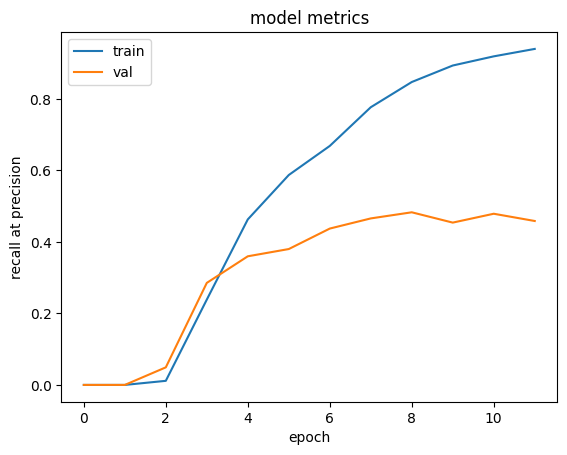

In [ ]:
print(model.history.history.keys())
plt.plot(model.history.history['rec@prec'])
plt.plot(model.history.history['val_rec@prec'])
plt.title('model metrics')
plt.ylabel('recall at precision')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

### Задание 2 (2 балла)
Обучите нейросеть со сверточными слоями с архитектурой похожей на Unet - https://en.wikipedia.org/wiki/U-Net

Не нужно воспроизводить все в точности, главное, чтобы было сокращение длины последовательности с помощью CNN, а затем обратное увеличение длины последовательности до изначальной с residual связями между промежуточными шагами с одинаковыми размерностями.
Изменений размерности должно быть хотя бы 3 и соответственно residual связей тоже.

Для повышения размерности используйте keras.layers.UpSampling1D
Полученная модель должна давать ненулевое качество на той же самой задаче классификации текстов.

In [23]:
inputs_unet = keras.layers.Input(shape=(MAX_LEN,))

In [38]:
embeddings = keras.layers.Embedding(input_dim=len(word2id), output_dim=100)(inputs_unet, )
#encoder
encode1 = keras.layers.Conv1D(kernel_size=5, filters=64, padding='same', activation='relu')(embeddings)
encode1 = keras.layers.Conv1D(kernel_size=5, filters=64, padding='same', activation='relu')(encode1)
pooling1 = keras.layers.MaxPooling1D(pool_size=2)(encode1)
encode2 = keras.layers.Conv1D(kernel_size=5, filters=128, padding='same', activation='relu')(pooling1)
encode2 = keras.layers.Conv1D(kernel_size=5, filters=128, padding='same', activation='relu')(encode2)
pooling2 = keras.layers.MaxPooling1D(pool_size=2)(encode2)
encode3 = keras.layers.Conv1D(kernel_size=5, filters=256, padding='same', activation='relu')(pooling2)
encode3 = keras.layers.Conv1D(kernel_size=5, filters=256, padding='same', activation='relu')(encode3)
pooling3 = keras.layers.MaxPooling1D(pool_size=2)(encode3)

#bottleneck/bridge
bridge = keras.layers.Conv1D(kernel_size=5, filters=512, padding='same', activation='relu')(pooling3)
bridge = keras.layers.Conv1D(kernel_size=5, filters=512, padding='same', activation='relu')(bridge)

#unsampling: decoder
upsampling1 = keras.layers.UpSampling1D(size=2)(bridge)
concat1 = keras.layers.Concatenate()([upsampling1, encode3])
decode1 = keras.layers.Conv1D(kernel_size=5, filters=256, padding='same', activation='relu')(concat1)
decode1 = keras.layers.Conv1D(kernel_size=5, filters=256, padding='same', activation='relu')(decode1)
upsampling2 = keras.layers.UpSampling1D(size=2)(conv4)
concat2 = keras.layers.Concatenate()([upsampling2, encode2])
decode2 = keras.layers.Conv1D(kernel_size=5, filters=128, padding='same', activation='relu')(concat2)
decode2 = keras.layers.Conv1D(kernel_size=5, filters=128, padding='same', activation='relu')(decode2)
upsampling3 = keras.layers.UpSampling1D(size=2)(conv5)
concat3 = keras.layers.Concatenate()([upsampling3, encode1])
decode3 = keras.layers.Conv1D(kernel_size=5, filters=64, padding='same', activation='relu')(concat3)
decode3 = keras.layers.Conv1D(kernel_size=5, filters=64, padding='same', activation='relu')(decode3)

flatten = keras.layers.Flatten()(decode3)
outputs_unet = keras.layers.Dense(units=len(label2id), activation='softmax')(flatten)

model_unet = keras.Model(inputs=inputs_unet, outputs=outputs_unet)
optimizer_unet = keras.optimizers.Adam(learning_rate=0.001)
model_unet.compile(optimizer=optimizer_unet,
              loss='categorical_crossentropy',
              metrics=[keras.metrics.RecallAtPrecision(0.8, name='rec@prec')],
              )

In [39]:
model_unet.save('model_unet.keras')
model_unet = keras.models.load_model('model_unet.keras')
model_unet.save_weights('model_unet.weights.h5')

/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 74 variables whereas the saved optimizer has 2 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [40]:
checkpoint = keras.callbacks.ModelCheckpoint('model_unet.weights.h5',
                                                monitor='val_rec@prec',
                                                verbose=1,
                                                save_weights_only=True,
                                                save_best_only=True,
                                                mode='max',
                                                save_freq='epoch'
                                               )
early_stop = keras.callbacks.EarlyStopping(monitor='val_rec@prec',
                                              min_delta=0.01,
                                              patience=3,
                                              verbose=1,
                                              mode='max',
                                              )

In [ ]:
embeddings = keras.layers.Embedding(input_dim=len(word2id), output_dim=100)(inputs_unet, )
#encoder
encode1 = keras.layers.Conv1D(kernel_size=5, filters=64, padding='same', activation='relu')(embeddings)
encode1 = keras.layers.Conv1D(kernel_size=5, filters=64, padding='same', activation='relu')(encode1)
pooling1 = keras.layers.MaxPooling1D(pool_size=2)(encode1)
encode2 = keras.layers.Conv1D(kernel_size=5, filters=128, padding='same', activation='relu')(pooling1)
encode2 = keras.layers.Conv1D(kernel_size=5, filters=128, padding='same', activation='relu')(encode2)
pooling2 = keras.layers.MaxPooling1D(pool_size=2)(encode2)
encode3 = keras.layers.Conv1D(kernel_size=5, filters=256, padding='same', activation='relu')(pooling2)
encode3 = keras.layers.Conv1D(kernel_size=5, filters=256, padding='same', activation='relu')(encode3)
pooling3 = keras.layers.MaxPooling1D(pool_size=2)(encode3)

#bottleneck/bridge
bridge = keras.layers.Conv1D(kernel_size=5, filters=512, padding='same', activation='relu')(pooling3)
bridge = keras.layers.Conv1D(kernel_size=5, filters=512, padding='same', activation='relu')(bridge)

#unsampling: decoder
upsampling1 = keras.layers.UpSampling1D(size=2)(bridge)
concat1 = keras.layers.Concatenate()([upsampling1, encode3])
decode1 = keras.layers.Conv1D(kernel_size=5, filters=256, padding='same', activation='relu')(concat1)
decode1 = keras.layers.Conv1D(kernel_size=5, filters=256, padding='same', activation='relu')(decode1)
pooling4 = keras.layers.MaxPooling1D(pool_size=2)(decode1)
upsampling2 = keras.layers.UpSampling1D(size=2)(conv4)
concat2 = keras.layers.Concatenate()([upsampling2, encode2])
decode2 = keras.layers.Conv1D(kernel_size=5, filters=128, padding='same', activation='relu')(concat2)
decode2 = keras.layers.Conv1D(kernel_size=5, filters=128, padding='same', activation='relu')(decode2)
pooling5 = keras.layers.MaxPooling1D(pool_size=2)(decode2)
upsampling3 = keras.layers.UpSampling1D(size=2)(conv5)
concat3 = keras.layers.Concatenate()([upsampling3, encode1])
decode3 = keras.layers.Conv1D(kernel_size=5, filters=64, padding='same', activation='relu')(concat3)
decode3 = keras.layers.Conv1D(kernel_size=5, filters=64, padding='same', activation='relu')(decode3)
pooling6 = keras.layers.MaxPooling1D(pool_size=2)(decode3)

flatten = keras.layers.Flatten()(decode3)
outputs_unet = keras.layers.Dense(units=len(label2id), activation='softmax')(flatten)

model_unet = keras.Model(inputs=inputs_unet, outputs=outputs_unet)
optimizer_unet = keras.optimizers.Adam(learning_rate=0.001)
model_unet.compile(optimizer=optimizer_unet,
              loss='categorical_crossentropy',
              metrics=[keras.metrics.RecallAtPrecision(0.8, name='rec@prec')],
              )

In [41]:
model_unet.fit(X_train, y_train,
          validation_data=(X_valid, y_valid),
          batch_size=2500,
         epochs=100,
         callbacks=[checkpoint, early_stop])

Epoch 1/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - loss: 2.6057 - rec@prec: 0.0000e+00
Epoch 1: val_rec@prec improved from -inf to 0.00000, saving model to model_unet.weights.h5
17/17 ━━━━━━━━━━━━━━━━━━━━ 23s 1s/step - loss: 2.5971 - rec@prec: 0.0000e+00 - val_loss: 2.3124 - val_rec@prec: 0.0000e+00
Epoch 2/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - loss: 2.2601 - rec@prec: 1.1218e-04
Epoch 2: val_rec@prec improved from 0.00000 to 0.00090, saving model to model_unet.weights.h5
17/17 ━━━━━━━━━━━━━━━━━━━━ 23s 1s/step - loss: 2.2577 - rec@prec: 1.0991e-04 - val_loss: 2.0900 - val_rec@prec: 9.0171e-04
Epoch 3/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - loss: 2.0091 - rec@prec: 6.4918e-04
Epoch 3: val_rec@prec improved from 0.00090 to 0.06402, saving model to model_unet.weights.h5
17/17 ━━━━━━━━━━━━━━━━━━━━ 23s 1s/step - loss: 2.0061 - rec@prec: 7.1067e-04 - val_loss: 1.7967 - val_rec@prec: 0.0640
Epoch 4/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - loss: 1.6198 - rec@prec: 0.1109
Epoch 4:

dict_keys(['loss', 'rec@prec', 'val_loss', 'val_rec@prec'])


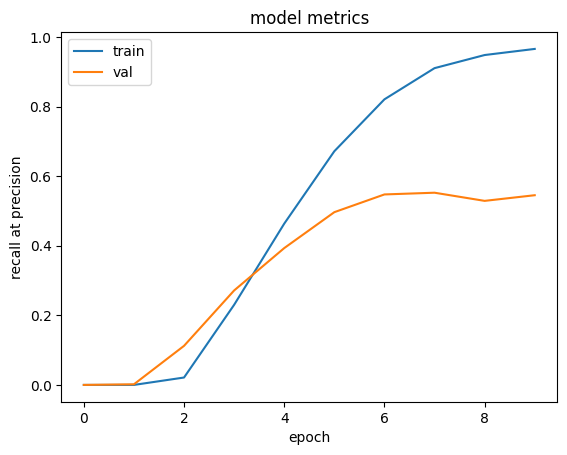

In [37]:
print(model_unet.history.history.keys())
plt.plot(model_unet.history.history['rec@prec'])
plt.plot(model_unet.history.history['val_rec@prec'])
plt.title('model metrics')
plt.ylabel('recall at precision')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

dict_keys(['loss', 'rec@prec', 'val_loss', 'val_rec@prec'])


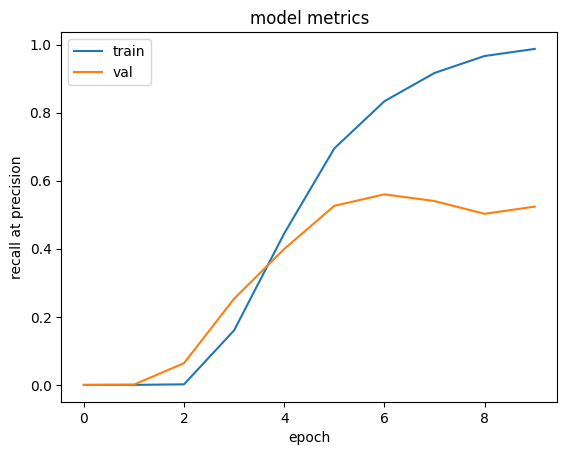

In [42]:
#с poolingами в декодере
print(model_unet.history.history.keys())
plt.plot(model_unet.history.history['rec@prec'])
plt.plot(model_unet.history.history['val_rec@prec'])
plt.title('model metrics')
plt.ylabel('recall at precision')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()